<a href="https://colab.research.google.com/github/MdHridoyMridha/BusTicket/blob/main/post_natal_model_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
# Set plot style
sns.set(style="whitegrid")

In [6]:
# PART 1: DATA LOADING & PREPROCESSING (MOVED TO TOP)
# ----------- Load dataset -----------

df = pd.read_csv("/content/post natal data.csv")  # Update path if needed

print(f"Initial shape: {df.shape}")
display(df.head())

Initial shape: (1503, 11)


,Timestamp,Age,Feeling sad or Tearful,Irritable towards baby & partner,Trouble sleeping at night,Problems concentrating or making decision,Overeating or loss of appetite,Feeling anxious,Feeling of guilt,Problems of bonding with baby,Suicide attempt
0,6/14/2022 20:02,35-40,Yes,Yes,Two or more days a week,Yes,Yes,Yes,No,Yes,Yes
1,6/14/2022 20:03,40-45,Yes,No,No,Yes,Yes,No,Yes,Yes,No
2,6/14/2022 20:04,35-40,Yes,No,Yes,Yes,Yes,Yes,No,Sometimes,No
3,6/14/2022 20:05,35-40,Yes,Yes,Yes,Yes,No,Yes,Maybe,No,No
4,6/14/2022 20:06,40-45,Yes,No,Two or more days a week,Yes,No,Yes,No,Yes,No


In [7]:
# ----------- Data Cleaning & Standardization -----------

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False)

In [8]:
# 3. Define Mappings
mapping = {
    "Yes": 1, "No": 0, "Sometimes": 0.5, "Maybe": 0.5, "None": 0,
    "Two or more days a week": 1
}

symptom_cols = [
    'feeling_sad_or_tearful', 'irritable_towards_baby_&_partner',
    'trouble_sleeping_at_night', 'problems_concentrating_or_making_decision',
    'overeating_or_loss_of_appetite', 'feeling_anxious',
    'feeling_of_guilt', 'problems_of_bonding_with_baby',
    'suicide_attempt'
]

for col in symptom_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().map(mapping).fillna(0)

In [9]:
# 4. Target Creation
df['risk_score'] = df[symptom_cols].sum(axis=1)

def classify_risk(score):
    if score <= 3: return "Low"
    elif score <= 6: return "Moderate"
    else: return "High"

df['risk_level'] = df['risk_score'].apply(classify_risk)

In [10]:
# 5. Prepare Features (X)
X_raw = df.drop(columns=['risk_level', 'risk_score', 'timestamp', 'index'], errors='ignore')

In [12]:
# Save columns for custom prediction later
training_columns = pd.get_dummies(X_raw, drop_first=True).columns

X = pd.get_dummies(X_raw, drop_first=True)
X_values = X.values.astype(float)

In [13]:
# 6. Prepare Target (y)
le = LabelEncoder()
y_integers = le.fit_transform(df['risk_level'])
num_classes = len(np.unique(y_integers))
y_one_hot = np.eye(num_classes)[y_integers]

In [15]:
# 7. Split and Scale
X_train, X_test, y_train, y_test = train_test_split(X_values, y_one_hot, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Preprocessing Complete.\n")

Data Preprocessing Complete.



In [16]:
# ==============================================================================
# PART 2: NEURAL NETWORK CLASS (LOGIC)
# ==============================================================================
class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        np.random.seed(42)
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.sigmoid(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.softmax(self.Z2)
        return self.A2

    def backward(self, X, y_one_hot, learning_rate=0.1):
        m = X.shape[0]
        dZ2 = self.A2 - y_one_hot
        dW2 = (1 / m) * np.dot(self.A1.T, dZ2)
        db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)
        dZ1 = np.dot(dZ2, self.W2.T) * self.sigmoid_derivative(self.A1)
        dW1 = (1 / m) * np.dot(X.T, dZ1)
        db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)

        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def train(self, X, y_one_hot, epochs=1000, learning_rate=0.1):
        loss_history = []
        print(f"Starting training on {X.shape[0]} samples...")

        for i in range(epochs):
            y_pred = self.forward(X)
            loss = -np.mean(np.sum(y_one_hot * np.log(y_pred + 1e-9), axis=1))
            loss_history.append(loss)
            self.backward(X, y_one_hot, learning_rate)

            if i % 500 == 0:
                print(f"Epoch {i}: Loss = {loss:.4f}")

        print("Training Complete.")
        return loss_history

    def predict(self, X):
        y_pred_probs = self.forward(X)
        return np.argmax(y_pred_probs, axis=1)

Starting training on 1202 samples...
Epoch 0: Loss = 1.1067
Epoch 500: Loss = 0.3823
Epoch 1000: Loss = 0.1515
Epoch 1500: Loss = 0.0988
Epoch 2000: Loss = 0.0749
Epoch 2500: Loss = 0.0606
Training Complete.


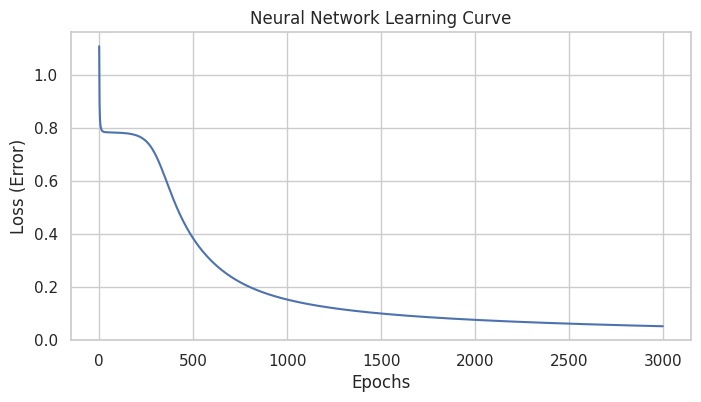


Model Accuracy on Test Set: 98.67%


In [17]:
# PART 3: TRAINING & PLOTTING
# ==============================================================================

# Initialize Network
nn = SimpleNeuralNetwork(input_size=X_train_scaled.shape[1], hidden_size=32, output_size=3)
loss_curve = nn.train(X_train_scaled, y_train, epochs=3000, learning_rate=0.1)

# --- PLOTTING CODE IS HERE ---
plt.figure(figsize=(8, 4))
plt.plot(loss_curve)  # This creates the line chart
plt.title("Neural Network Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss (Error)")
plt.show()  # This displays the chart
# -----------------------------

# Accuracy Check
y_pred_indices = nn.predict(X_test_scaled)
y_true_indices = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred_indices == y_true_indices)
print(f"\nModel Accuracy on Test Set: {accuracy * 100:.2f}%")


In [18]:
# PART 4: CUSTOM INPUT PREDICTION
# ==============================================================================
print("\n" + "="*40)
print("CUSTOM INPUT PREDICTION")
print("="*40)

def predict_new_patient(patient_data):
    # 1. Convert to DataFrame
    input_df = pd.DataFrame([patient_data])

    # 2. Map Symptoms
    for col in symptom_cols:
        if col in input_df.columns:
            input_df[col] = input_df[col].map(mapping).fillna(0)

    # 3. One-Hot Encode & Align Columns
    input_encoded = pd.get_dummies(input_df, drop_first=True)
    input_aligned = input_encoded.reindex(columns=training_columns, fill_value=0)

    # 4. Scale
    input_scaled = scaler.transform(input_aligned.values)

    # 5. Predict
    pred_probs = nn.forward(input_scaled)
    pred_idx = np.argmax(pred_probs)
    pred_label = le.inverse_transform([pred_idx])[0]

    return pred_label, pred_probs[0][pred_idx] * 100

# --- CHANGE THESE VALUES TO TEST DIFFERENT PEOPLE ---
custom_input = {
    'age': '40-45',
    'feeling_sad_or_tearful': 'Yes',
    'irritable_towards_baby_&_partner': 'No',
    'trouble_sleeping_at_night': 'Two or more days a week',
    'problems_concentrating_or_making_decision': 'Yes',
    'overeating_or_loss_of_appetite': 'No',
    'feeling_anxious': 'Yes',
    'feeling_of_guilt': 'No',
    'problems_of_bonding_with_baby': 'Sometimes',
    'suicide_attempt': 'No'
}

print("Predicting for custom input:", custom_input)
result, confidence = predict_new_patient(custom_input)

print(f"\nPREDICTED RISK LEVEL: {result}")
print(f"Confidence: {confidence:.2f}%")


CUSTOM INPUT PREDICTION
Predicting for custom input: {'age': '40-45', 'feeling_sad_or_tearful': 'Yes', 'irritable_towards_baby_&_partner': 'No', 'trouble_sleeping_at_night': 'Two or more days a week', 'problems_concentrating_or_making_decision': 'Yes', 'overeating_or_loss_of_appetite': 'No', 'feeling_anxious': 'Yes', 'feeling_of_guilt': 'No', 'problems_of_bonding_with_baby': 'Sometimes', 'suicide_attempt': 'No'}

PREDICTED RISK LEVEL: Moderate
Confidence: 99.35%
